# Course 1: Classification and Vector Spaces
# Own project 2: Classifying a conversation using Naive Bayes

In this notebook I will apply the knowledge I gained from the previous notebooks to classify a conversation using Naive Bayes.

## 1. Training data

### 1.1 Importing and cleaning

For this own project (in spanish), the first problem is getting a spanish dataset that we can use to train our model.
For that, I will use a pre labeled dataset of spanish tweets.

Dataset source: http://tass.sepln.org/tass_data/download.php?auth=6tQassjsi4HeLvhe5rN

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Folder containing xml files: ../../datasets/es
# All xml have the structure
# <tweet>
# 		<tweetid>768220253730009091</tweetid>
# 		<user>Alis_8496</user>
# 		<content>@Yulian_Poe @guillermoterry1 Ah. mucho más por supuesto! solo que lo incluyo. Me habías entendido mal </content>
# 		<date>2016-08-23 22:55:55</date>
# 		<lang>es</lang>
# 		<sentiment>
# 			<polarity><value>P</value></polarity>
# 		</sentiment>
# 	</tweet>

# Read all xml into a pd dataframe. Keep only content and polarity value
folder = '../../datasets/es/'
files = os.listdir(folder)
df = pd.DataFrame()
for file in files:
    if file.endswith(".xml"):
        print("Parsing file: " + file)
        tree = ET.parse(folder + file)
        root = tree.getroot()
        for tweet in root:
            content = tweet.find('content')
            polarity = tweet.find('sentiment/polarity/value')
            if content is not None and polarity is not None:
                df = df.append({'content': content.text, 'polarity': polarity.text}, ignore_index=True)

Parsing file: general-train-tagged-3l.xml
Parsing file: general-train-tagged.xml
Parsing file: intertass-CR-train-tagged.xml
Parsing file: intertass-ES-train-tagged.xml
Parsing file: TASS2019_country_CR_train.xml
Parsing file: TASS2019_country_ES_train.xml
Parsing file: TASS2019_country_MX_train.xml
Parsing file: TASS2019_country_PE_train.xml
Parsing file: TASS2019_country_UY_train.xml


In [3]:
df.head()

,content,polarity
0,@NoilyMV yo soy totalmente puntual,NONE
1,@DexterAOM por eso es que se dice lo del final...,NEU
2,"@robertobrenes Bueno, no es tanto lo mayor com...",N
3,@doriamdiaz El de Halfon de Germinal se ve mor...,P
4,Ahorita me van a cambiar las ligas de los brak...,NONE


In [4]:
# Remove NONE polarity
df = df[df['polarity'] != 'NONE']
df['polarity'].value_counts()

# Remove NEUTRAL polarity
df = df[df['polarity'] != 'NEU']
df['polarity'].value_counts()

N    2613
P    1941
Name: polarity, dtype: int64

In [5]:
# Separate into positive and negative tweets
train_x_pos = df[df['polarity'] == 'P']
train_x_neg = df[df['polarity'] == 'N']

# Remove the difference in length between positive and negative tweets
len_final = len(train_x_pos) if len(train_x_pos) < len(train_x_neg) else len(train_x_neg)
train_x_pos = train_x_pos[:len_final]
train_x_neg = train_x_neg[:len_final]

# Keep only the content, transform content column to list
train_x_pos = train_x_pos['content'].tolist()
train_x_neg = train_x_neg['content'].tolist()

# Print length of positive and negative tweets
print("Length of positive tweets: " + str(len(train_x_pos)))
print("Length of negative tweets: " + str(len(train_x_neg)))

Length of positive tweets: 1941
Length of negative tweets: 1941


Import the IMDB dataset.

In [6]:
# Import imdb_clean.csv
df_imdb = pd.read_csv(folder + 'imdb_clean.csv')
df_imdb.head()

,review_es,sentimiento
0,Uno de los otros críticos ha mencionado que de...,positivo
1,Una pequeña pequeña producción.La técnica de f...,positivo
2,Pensé que esta era una manera maravillosa de p...,positivo
3,"Básicamente, hay una familia donde un niño peq...",negativo
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


In [7]:
# Separate the IMDB dataset into positive and negative tweets
imdb_pos = df_imdb[df_imdb['sentimiento'] == 'positivo']['review_es'].tolist()
imdb_neg = df_imdb[df_imdb['sentimiento'] == 'negativo']['review_es'].tolist()

# Append to the existing pos and neg lists
train_x_pos.extend(imdb_pos)
train_x_neg.extend(imdb_neg)

# Create the final training set
train_x = train_x_pos + train_x_neg
train_y = [1] * len(train_x_pos) + [0] * len(train_x_neg)

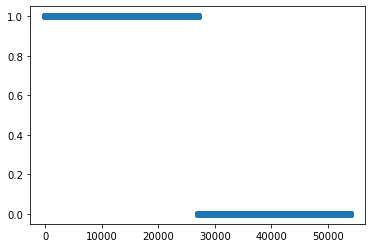

In [8]:
#plot train y over indexes. points
plt.scatter(range(len(train_y)), train_y)

In [9]:
# Shuffle train_x and train_y. Transform first to pandas, shuffle and transform back to list
df_shuffle = pd.DataFrame({'x': train_x, 'y': train_y})
df_shuffle = df_shuffle.reindex(np.random.permutation(df_shuffle.index))
train_x = df_shuffle['x'].tolist()
train_y = df_shuffle['y'].tolist()

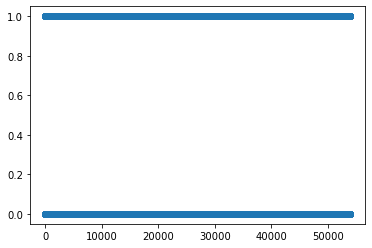

In [10]:
plt.scatter(range(len(train_y)), train_y)

In [11]:
# Print head of the training set x and y
print("Head of the training set x: ")
print(train_x[:5])
print("Head of the training set y: ")
print(train_y[:5])

Head of the training set x: 
["Si no has visto a Zombie Bloodbath, no lo has hecho. Un concurso como 'Haz tu propia película de terror en un día', no podría ocurrir una entrada que esta indignación de un insulto en la inteligencia de cualquier espectador. El Sr. Hoets olvidó una historia, una trama, un diálogo adecuado, el hecho de que las personas necesitan algunos talentos de acción básica y el diseñador de iluminación acreditado obviamente se olvidó de aparecer. Parece que se registra en la crujiente de Handycams, y copiado en un equipo peor aún. El efecto de maquillaje consiste en la máscara negra para que los zombies y el yogur se vierten sobre las cabezas de las personas para simular su fundición de la piel. Esto no es más que una película en casa, y una muy mala también. Solo divertido para observar a los amigos, familiares y vecinos que estaban dispuestos a aparecer por la filmación. No puedo por la vida de mí entender por qué esta burla de un producto se encuentra en cualquier

In [12]:
# From train sets, remove 20% and save as test sets
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = train_x[int(len(train_x) * 0.2):]
test_y = train_y[int(len(train_y) * 0.2):]
train_x = train_x[:int(len(train_x) * 0.2)]
train_y = train_y[:int(len(train_y) * 0.2)]

In [13]:
# Print length of all sets train and test for X and Y
print("Length of train_x: " + str(len(train_x)))
print("Length of train_y: " + str(len(train_y)))
print("Length of test_x: " + str(len(test_x)))
print("Length of test_y: " + str(len(test_y)))

print(type(train_x))
print(type(train_y))
print(type(test_x))
print(type(test_y))

Length of train_x: 10776
Length of train_y: 10776
Length of test_x: 43106
Length of test_y: 43106
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### 1.2 String cleaning, tokenization and stemming

For the spanish stopwords, I will be importing it from the internet and merge it with the spanish stopwords from the nltk library.
Link: https://github.com/Alir3z4/stop-words/blob/master/spanish.txt

In [14]:
import re
import unidecode
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

stopwords_es = stopwords.words('spanish')

# Import stopwords from txt
with open(folder + 'stopwords.txt', 'r') as f:
    stopwords_es.extend(f.read().splitlines())

# To lower, remove duplicates
stopwords_es = list(set(stopwords_es))
stopwords_es = [word.lower() for word in stopwords_es]

In [15]:
stemmer = SnowballStemmer('spanish')

def clean_string(tweet):
    """
    Input: 
        - tweet string
    Output:
        - tokenized, cleaned, and stemmed tweet
    """
    # Cleaning the text

    # To lower
    tweet = tweet.lower()
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    # Remove usernames
    tweet = re.sub(r'@\S+', '', tweet)
    # Remove hashtag symbol only
    tweet = re.sub(r'#', '', tweet)
    # Remove special characters
    tweet = re.sub(r'[^\w\s]', '', tweet)
    # Remove numbers
    tweet = re.sub(r'\d', '', tweet)

    # Tokenize
    tweet = TweetTokenizer(strip_handles=True, reduce_len=True).tokenize(tweet)

    # Remove stopwords
    tweet = [word for word in tweet if word not in stopwords_es]

    # Stemming
    tweet = [stemmer.stem(word) for word in tweet]

    return tweet

## 2. Training the model

In [16]:
# Count tweets function
def count_words(result, texts, ys):
    """
    Input:
        - result: dictionary containing a pair (word, label) and its frequency
        - texts: a list of texts
        - ys: a list of labels
    Output:
        - result: dictionary containing a pair (word, label) and its frequency
    """
    for y, text in tqdm(zip(ys, texts), total=len(texts)):
        tokens = clean_string(text)
        for word in tokens:
            pair = (word, y)
            if pair in result:
                result[pair] += 1
            else:
                result[pair] = 1
    return result

In [17]:
result = {}
tweets = ["Amo a mi gato", "Me gusta el cine", "No me gusta el marisco"]
ys = [1, 1, 0]
count_words(result, tweets, ys)

100%|██████████| 3/3 [00:00<00:00, 214.32it/s]


{('amo', 1): 1,
 ('gat', 1): 1,
 ('gust', 1): 1,
 ('cin', 1): 1,
 ('gust', 0): 1,
 ('marisc', 0): 1}

In [18]:
freqs = count_words({}, train_x, train_y)

100%|██████████| 10776/10776 [01:14<00:00, 144.26it/s]


In [19]:
def lookup(freqs, word, label):
    '''
    Input:
        freqs: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Output:
        n: the number of times the word with its corresponding label appears.
    '''
    n = 0  # freqs.get((word, label), 0)

    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]

    return n

In [20]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of tweets
        train_y: a list of labels correponding to the tweets (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += 1

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += 1

    # Calculate D, the number of documents
    D = len(train_y)

    # Calculate D_pos, the number of positive documents (*hint: use sum(<np_array>))
    D_pos = np.sum(train_y)

    # Calculate D_neg, the number of negative documents (*hint: compute using D and D_pos)
    D_neg = D - D_pos

    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = lookup(freqs, word, 1)
        freq_neg = lookup(freqs, word, 0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos) - np.log(p_w_neg)

    ### END CODE HERE ###

    return logprior, loglikelihood

In [28]:
# If naive_results.pkl file exists inport, else create
if os.path.exists(folder + 'naive_results.pkl'):
    with open(folder + 'naive_results.pkl', 'rb') as f:
        naive_results = pickle.load(f)
else:
    naive_results = {}
    naive_results['logprior'], naive_results['loglikelihood'] = train_naive_bayes(freqs, train_x, train_y)
    with open(folder + 'naive_results.pkl', 'wb') as f:
        pickle.dump(naive_results, f)

0.004083153408609874
71824


## Testing the model

In [48]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def naive_bayes_predict(tweet, logprior, loglikelihood):
    '''
    Input:
        tweet: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)

    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # process the tweet to get a list of words
    word_l = clean_string(tweet)

    # initialize probability to zero
    p = 0

    # add the logprior
    p += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]

    ### END CODE HERE ###

    return p

In [23]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of tweets
        test_y: the corresponding labels for the list of tweets
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of tweets classified correctly)/(total # of tweets)
    """
    accuracy = 0  # return this properly

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    y_hats = []
    for tweet in tqdm(test_x):
        # if the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.absolute(y_hats-test_y))

    # Accuracy is 1 minus the error
    accuracy = 1-error

    ### END CODE HERE ###

    return accuracy

In [24]:
print("Naive Bayes accuracy = %0.4f" %
      (test_naive_bayes(test_x, test_y, logprior, loglikelihood)))

100%|██████████| 43106/43106 [04:54<00:00, 146.29it/s]

Naive Bayes accuracy = 0.8025


Now this is much better than the previous notebook which had 0.6 accuracy.

## Analyze my tweets

In [36]:
import pickle
# Import tweets.pkl
with open('tweets.pkl', 'rb') as f:
    tweets = pickle.load(f)
tweets = [tweet.full_text for tweet in tweets]

In [54]:
# Predict
text = "Que ricos estaban los cereales"
print(naive_bayes_predict(text, logprior, loglikelihood))
text = "Nop me ha gustado anda la comida de hoy"
print(naive_bayes_predict(text, logprior, loglikelihood))

-0.3359628452756205
-0.03643020971222288


In [62]:
import swifter

# tweets_df. column text = tweets, prediction = ""
tweets_df = pd.DataFrame(tweets, columns=['text'])
tweets_df['prediction'] = tweets_df['text'].swifter.apply(lambda tweet: naive_bayes_predict(tweet, logprior, loglikelihood))


Pandas Apply:   0%|          | 0/2174 [00:00<?, ?it/s]

In [65]:
# Print 5 random tweets with the predicted class
print(tweets_df.sample(5))

                                                   text  prediction
806                             @aucsi ansioso espero 😎   -0.161808
76                             @cyberlentejas Kaczynski    0.004083
1642                           qe bonita la luna amigos    1.422869
1719  4 masibon qe me meto en el dia gracias ansieda...    3.344203
659   1h de jornada laboral y ya estoy hasta los huevos    0.972390


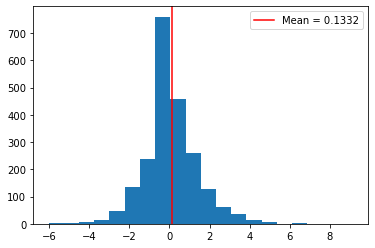

In [95]:
# Save the predictions in a list
preds_list = tweets_df['prediction'].tolist()

mean = np.mean(preds_list)
plt.hist(preds_list, bins=20)
plt.axvline(mean, color='r')
plt.legend(['Mean = %0.4f' % mean])

plt.show()

In [100]:
# Check if any prediction is above 5 sigma or below -5 sigma
sigma = np.std(preds_list)
important = np.where((preds_list > 5*sigma) | (preds_list < -5*sigma))

# Print the important tweets
for i in important[0]:
    print(tweets_df.iloc[i]['text'])
    print(tweets_df.iloc[i]['prediction'])
    print()

pros de terminar examenes: terminas examenes
cons: tener qe recoger la cuadra de cuarto en la qe he estao viviendo sin cuidao alguno qe de vd parece q han vivio aqi 2 yeguas
7.01601365032189

otra vez mi familia diciendo qe enseñe los tatus y las cosas como si fuera un escaparate delante to la familia y qe qe son qe por qe me los hago mira me tenio qe levantar e irme qe ansiedad qe incomodidad
9.146069474044628



As we can see, both tweets are somewhat negative. This may be because my tweets are written with abbreviations and my tweets may have not been well stemmed.